<a href="https://colab.research.google.com/github/codeSamuraii/ml-experiments/blob/main/TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Library from Part 1

In [1]:
import os
import pathlib
import tempfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from random import choice
from itertools import chain
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential



quality_factor = 5 # @param {type:"slider", min:0, max:90, step:1}
batch_size = 8 # @param {type:"slider", min:4, max:32, step:2}
img_height = 500
img_width = 500


def process_images_for_training(src_dataset, dest_directory, ext_glob=None):
    # Images have different extensions
    folder = pathlib.Path(src_dataset).resolve()
    extensions = ext_glob or {'*.jpg', '*.jpeg'}
    images = list(chain.from_iterable(folder.glob(ext) for ext in extensions))
    nb_img, nb_errors = len(images), 0
    print(f'Found {nb_img} images.')

    for i, image_file in enumerate(images):
        try:
            im = Image.open(image_file, formats=['JPEG'])
            im.save(f'{dest_directory}/quality/{i}.jpg', optimize=True, quality='keep')
        except (OSError, ValueError):
            nb_errors += 1
            continue

        im.save(f'{dest_directory}/compressed/{i}.jpg', optimize=False, quality=quality_factor)

        if i % 1000 == 0:
            progress = int(i / nb_img * 100)
            print(f'{progress}% ({i}/{nb_img} E={nb_errors})')

    print('Done.')

def dataset_from_directory(training_dir, seed=321):
    train_dataset = tf.keras.utils.image_dataset_from_directory(
        training_dir,
        validation_split=0.2,
        subset='training',
        seed=seed,
        image_size=(img_height, img_width),
        crop_to_aspect_ratio=True,
        # label_mode='binary',
        batch_size=batch_size
    )
    validation_dataset = tf.keras.utils.image_dataset_from_directory(
        training_dir,
        validation_split=0.2,
        subset='validation',
        seed=seed,
        image_size=(img_height, img_width),
        crop_to_aspect_ratio=True,
        # label_mode='binary',
        batch_size=batch_size
    )

    return train_dataset, validation_dataset

def show_dataset(dataset):
    plt.figure(figsize=(12, 9))
    for images, labels in dataset.take(1):
      for i in range(batch_size):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

    image_batch, _ = next(iter(dataset))
    first_image = image_batch[0]
    print(f'Pixel values in [{np.min(first_image)}:{np.max(first_image)}]')

def plot_performance(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    nb_epochs = len(history.history['val_loss'])
    epochs_range = range(nb_epochs)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

def gen_random_class_and_images(n):
    compressed_files = list(pathlib.Path(f'/content/training/compressed').glob('*.jpg'))
    quality_files = list(pathlib.Path(f'/content/training/quality').glob('*.jpg'))
    classes = [
        ('compressed', lambda: random.choice(compressed_files)),
        ('quality', lambda: random.choice(quality_files))
    ]

    for _ in range(n):
        rand_class, rand_img = random.choice(classes)
        yield rand_class, rand_img()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Kaggle credentials

In [3]:
import os
import getpass

kaggle_ids = getpass.getpass('Content of your ~/.kaggle/kaggle.json: ')
os.environ['KAGGLE_JSON'] = kaggle_ids

!mkdir ~/.kaggle; echo $KAGGLE_JSON > ~/.kaggle/kaggle.json; chmod 600 ~/.kaggle/kaggle.json

Content of your ~/.kaggle/kaggle.json: ··········


# Improving generalization with transfer learning
_This is the second part of the project, first part [here](https://github.com/codeSamuraii/ml-experiments/blob/main/CompressionDetection.ipynb).
You can run the library above to import previous functions._

Our current model is able to differentiate compressed _landscape_ images from original ones. However, it wouldn't perform well with a different kind of picture.

Using transfer learning and a different set of pictures, we'll improve our model ability to generalize.

## Download and prepare the new dataset
_You'll need a [Kaggle account](#scrollTo=-TddKzWIFhwu&line=1&uniqifier=1) to download the dataset._

Just like before, we'll download an image dataset and process images into two categories:

In [4]:
!mkdir /content/dataset2; kaggle datasets download -d farhanhaikhan/general-purpose-image-dataset -p /content/dataset2 --unzip; mv dataset2/dataset/* dataset2/

100% 1.45G/1.45G [01:09<00:00, 24.7MB/s]
100% 1.45G/1.45G [01:09<00:00, 22.6MB/s]


Each image is compressed to the `training2/compressed` folder while originals are saved to `training2/quality`.

In [5]:
!mkdir /content/training2; mkdir /content/training2/compressed; mkdir /content/training2/quality

process_images_for_training('/content/dataset2', '/content/training2', ext_glob={'*/*.jpg', '*/*.jpeg'})

Found 5894 images.
0% (0/5894 E=0)
16% (1000/5894 E=21)
33% (2000/5894 E=41)
50% (3000/5894 E=62)
67% (4000/5894 E=81)
84% (5000/5894 E=104)
Done.


We create the Keras/TF dataset:

Found 11552 files belonging to 2 classes.
Using 9242 files for training.
Found 11552 files belonging to 2 classes.
Using 2310 files for validation.
2 classes: ['compressed', 'quality']
Pixel values in [0.0:255.0]


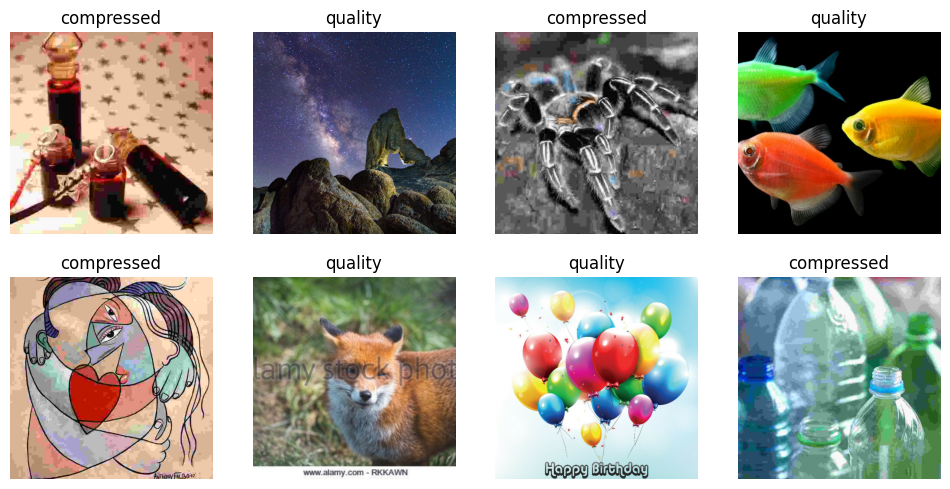

In [2]:
train_dataset_2, validation_dataset_2 = dataset_from_directory('/content/training2', seed=123)

class_names = train_dataset_2.class_names
num_classes = len(class_names)
print(f'{num_classes} classes: {class_names}')

show_dataset(train_dataset_2)

## Creating a new model from the previous one
We'll first load the model we want to use as a base for our transfer learning, connect new dense layers (discarding the base model's final prediction layer) and freeze the convolution layers with `layer.trainable=False`.

In [3]:
from keras.models import load_model, Model


# Check if base model has already been loaded
try:
    model_file
except NameError:
    model_file = input('Path to .keras model: ')
try:
    base_model
except NameError:
    base_model = load_model(model_file)

base_model.summary()

Path to .keras model: /content/landscape_q5_987.keras
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 500, 500, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 500, 500, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 250, 250, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 250, 250, 64)      18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 125, 125, 64)      0         
 ng2D)                                                           
                                                                 


In [4]:
base, new_model = None, None
# We discard the dense layers
base = base_model.layers[len(base_model.layers) - 5].output

# We add new dense layers
new_model = layers.Dense(1024, activation='relu')(base)
new_model = layers.Dropout(0.2)(new_model)
new_model = layers.Dense(128, activation='relu')(new_model)
new_model = layers.Dense(num_classes, activation='softmax')(new_model)
new_model = Model(inputs=base_model.input, outputs=new_model)

nb_layers_new = len(new_model.layers)
nb_layers_to_train = nb_layers_new - 4

# We freeze every layer except the four we just added
for i in range(1, nb_layers_to_train):
    new_model.layers[i].trainable = False
for i in range(nb_layers_to_train, nb_layers_new):
    new_model.layers[i].trainable = True


new_model.summary(expand_nested=True, show_trainable=True)

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 sequential_6_input (InputL  [(None, 500, 500, 3)]     0         Y          
 ayer)                                                                      
                                                                            
 sequential_6 (Sequential)   (None, 500, 500, 3)       0         N          
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| random_flip_3 (RandomFlip  (None, 500, 500, 3)       0         N         |
| )                                                                        |
|                                                                          |
| random_zoom_3 (RandomZoom  (None, 500, 500, 3)       0         N         |
| )                                                                        |
|                                                            

Epoch 1/25
1156/1156 [==============================] - ETA: 0s - loss: 0.1509 - accuracy: 0.9366

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1156/1156 [==============================] - 83s 69ms/step - loss: 0.1509 - accuracy: 0.9366 - val_loss: 0.1177 - val_accuracy: 0.9541
Epoch 2/25
1156/1156 [==============================] - 80s 69ms/step - loss: 0.1285 - accuracy: 0.9454 - val_loss: 0.1112 - val_accuracy: 0.9589
Epoch 3/25
1156/1156 [==============================] - 87s 75ms/step - loss: 0.1205 - accuracy: 0.9517 - val_loss: 0.1076 - val_accuracy: 0.9545
Epoch 4/25
1156/1156 [==============================] - 82s 71ms/step - loss: 0.1205 - accuracy: 0.9488 - val_loss: 0.1035 - val_accuracy: 0.9558
Epoch 5/25
1156/1156 [==============================] - 86s 74ms/step - loss: 0.1182 - accuracy: 0.9487 - val_loss: 0.1022 - val_accuracy: 0.9558
Epoch 6/25
1156/1156 [==============================] - 90s 78ms/step - loss: 0.1128 - accuracy: 0.9541 - val_loss: 0.1020 - val_accuracy: 0.9589
Epoch 7/25
1156/1156 [==============================] - 81s 70ms/step - loss: 0.1061 - accuracy: 0.9565 - val_loss: 0.1013 - val_accura

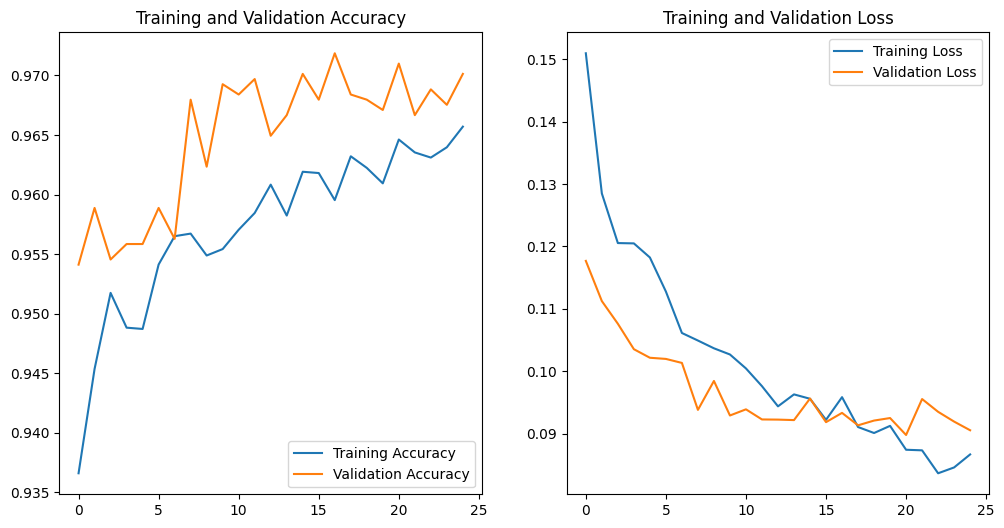

In [5]:
!rm /tmp/checkpoint_* 2> /dev/null
import tempfile
import tensorflow as tf


new_model.compile(optimizer='Adamax',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

_, checkpoint_file = tempfile.mkstemp(prefix='checkpoint_', suffix='.h5', dir='/tmp')
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_file, save_best_only=True)
early_stop = tf.keras.callbacks.EarlyStopping(patience=5, start_from_epoch=5, restore_best_weights=True)

history_2 = new_model.fit(train_dataset_2, epochs=25, validation_data=validation_dataset_2, callbacks=[checkpoint, early_stop])

loss, accuracy = new_model.evaluate(validation_dataset_2)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

plot_performance(history_2)

In [6]:
file_name = f'general_q{quality_factor}_{int(accuracy * 1000)}'

new_model.save(f'/content/{file_name}.keras')
!cp /content/{file_name}.keras /content/drive/MyDrive/trained_models/{file_name}.keras

new_model.save(f'/tmp/{file_name}.h5')
!tflite_convert --keras_model_file='/tmp/{file_name}.h5' --output_file='/content/{file_name}.tflite'
!cp /content/{file_name}.tflite /content/drive/MyDrive/trained_models/{file_name}.tflite

2023-09-19 12:36:58.344501: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-09-19 12:37:01.650726: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-09-19 12:37:12.127989: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.88GiB (rounded to 2015363072)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-09-19 12:37:12.128102: W tensorflow/tsl/framework/bfc_allocator.cc:497] *______*****___________________________***************______________________________________________
2023-09-19 12:37:12.128150: W tensorflow/core/framework/op_kernel.cc